<a href="https://colab.research.google.com/github/robert-shepherd/fpl/blob/main/Project_3_2_linear_regression_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear regression model


---

The purpose of this script is to develop the linear regression model

Data sources:
* Data post feature engineering:  https://raw.githubusercontent.com/robert-shepherd/fpl/main/fpl_features.csv


In [ ]:
# Loading libraries
import pandas as pd
import pickle
import numpy as np
import scipy.stats as stats
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from statsmodels.api import qqplot

# Model libraries
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.nonparametric.smoothers_lowess import lowess

# Import measures
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Setup

In [ ]:
# Reading in files from static output
X_train_url = 'https://raw.githubusercontent.com/robert-shepherd/fpl/main/X_train.csv'
X_test_url = 'https://raw.githubusercontent.com/robert-shepherd/fpl/main/X_test.csv'
Y_train_url = 'https://raw.githubusercontent.com/robert-shepherd/fpl/main/Y_train.csv'
Y_test_url = 'https://raw.githubusercontent.com/robert-shepherd/fpl/main/Y_test.csv'

X_train = pd.read_csv(X_train_url)
X_test = pd.read_csv(X_test_url)
Y_train = pd.read_csv(Y_train_url,squeeze=True)
Y_test = pd.read_csv(Y_test_url,squeeze=True)

print('X_train      : ',X_train.shape)
print('X_test       : ',X_test.shape)
print('Y_train      : ',Y_train.shape)
print('Y_test       : ',Y_test.shape)

X_train      :  (40388, 40)
X_test       :  (10098, 40)
Y_train      :  (40388,)
Y_test       :  (10098,)


In [ ]:
# Removing missing from initial checks
train_na = X_train.isnull().any(axis=1)
test_na = X_test.isnull().any(axis=1)

X_train_no_na = X_train[~train_na]
Y_train_no_na = Y_train[~train_na]

X_test_no_na = X_test[~test_na]
Y_test_no_na = Y_test[~test_na]

print('X_train_no_na      : ',X_train_no_na.shape)
print('X_test_no_na       : ',X_test_no_na.shape)
print('Y_train_no_na      : ',Y_train_no_na.shape)
print('Y_test_no_na       : ',Y_test_no_na.shape)

X_train_no_na      :  (32698, 40)
X_test_no_na       :  (8195, 40)
Y_train_no_na      :  (32698,)
Y_test_no_na       :  (8195,)


## Linear regression with all variables

In [ ]:
# Build OLS linear regression model
ols_model = sm.OLS(Y_train_no_na, X_train_no_na)
ols_model_fitted = ols_model.fit()

In [ ]:
#Fitted results
print(ols_model_fitted.summary())

                                 OLS Regression Results                                
Dep. Variable:           total_points   R-squared (uncentered):                   0.447
Model:                            OLS   Adj. R-squared (uncentered):              0.447
Method:                 Least Squares   F-statistic:                              660.5
Date:                Fri, 07 May 2021   Prob (F-statistic):                        0.00
Time:                        08:07:36   Log-Likelihood:                         -71757.
No. Observations:               32698   AIC:                                  1.436e+05
Df Residuals:                   32658   BIC:                                  1.439e+05
Df Model:                          40                                                  
Covariance Type:            nonrobust                                                  
                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------

In [ ]:
# Predicting on test
y_pred_ols = ols_model_fitted.predict(X_test_no_na)

In [ ]:
# Checking min/max prediction
min_pred = min(y_pred_ols)
max_pred = max(y_pred_ols)
print("Min prediction: {}".format(min_pred))
print("Max prediction: {}".format(max_pred))

Min prediction: -0.4632575600872477
Max prediction: 7.185662370055654


In [ ]:
# Checking MSE
mse = mean_squared_error(Y_test_no_na, y_pred_ols)
print("Test MSE: {}".format(mse))

Test MSE: 4.784088103596704


In [ ]:
# Comparing MSE to the null model (i.e. take mean of y train)
avg = np.mean(Y_train_no_na)
y_avg = [avg] * len(X_test_no_na)
mse_avg = mean_squared_error(Y_test_no_na, y_avg)
print("Benchmark MSE: {}".format(mse_avg))

Benchmark MSE: 6.366269097205641


In [ ]:
# Checking R2
r2 = r2_score(Y_test_no_na, y_pred_ols)
print("Test R2: {}".format(r2))

Test R2: 0.2485247561576862


### Diagnostic plots with raw predictions

In [ ]:
# Set up
residuals = ols_model_fitted.resid
fitted = ols_model_fitted.fittedvalues
smoothed = lowess(residuals,fitted)

# Setting default Seaborn style
sns.set()

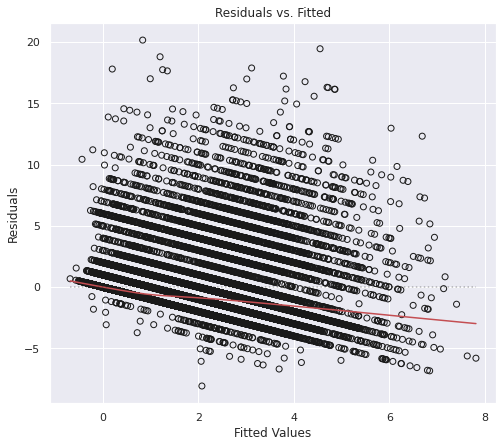

In [ ]:
# Checking residuals
plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (8,7)
fig, ax = plt.subplots()
ax.scatter(fitted, residuals, edgecolors = 'k', facecolors = 'none')
ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
ax.set_ylabel('Residuals')
ax.set_xlabel('Fitted Values')
ax.set_title('Residuals vs. Fitted')
ax.plot([min(fitted),max(fitted)],[0,0],color = 'k',linestyle = ':', alpha = .3)

plt.show()

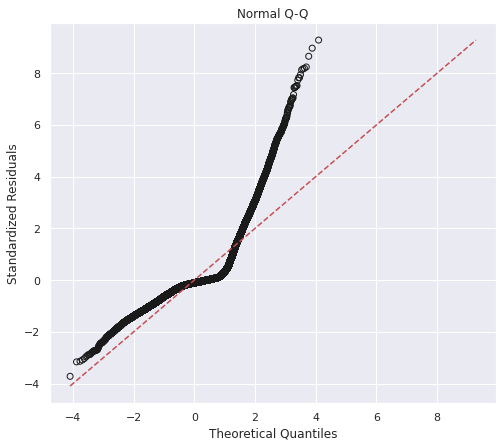

In [ ]:
# Checking QQ plot
sorted_student_residuals = pd.Series(ols_model_fitted.get_influence().resid_studentized_internal)
sorted_student_residuals.index = ols_model_fitted.resid.index
sorted_student_residuals = sorted_student_residuals.sort_values(ascending = True)
df = pd.DataFrame(sorted_student_residuals)
df.columns = ['sorted_student_residuals']
df['theoretical_quantiles'] = stats.probplot(df['sorted_student_residuals'], dist = 'norm', fit = False)[0]
rankings = abs(df['sorted_student_residuals']).sort_values(ascending = False)

fig, ax = plt.subplots()
x = df['theoretical_quantiles']
y = df['sorted_student_residuals']
ax.scatter(x,y, edgecolor = 'k',facecolor = 'none')
ax.set_title('Normal Q-Q')
ax.set_ylabel('Standardized Residuals')
ax.set_xlabel('Theoretical Quantiles')
ax.plot([np.min([x,y]),np.max([x,y])],[np.min([x,y]),np.max([x,y])], color = 'r', ls = '--')

plt.show()

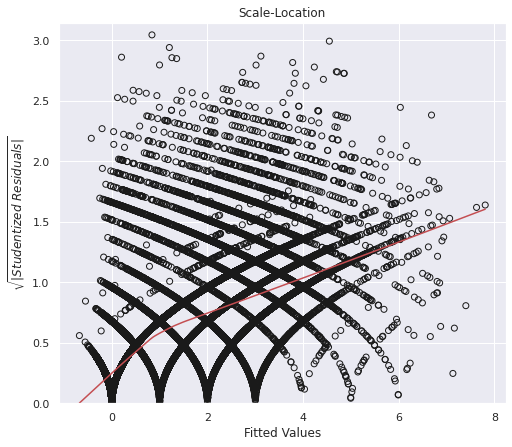

In [ ]:
# Scale-Location plot
student_residuals = ols_model_fitted.get_influence().resid_studentized_internal
sqrt_student_residuals = pd.Series(np.sqrt(np.abs(student_residuals)))
sqrt_student_residuals.index = ols_model_fitted.resid.index
smoothed = lowess(sqrt_student_residuals,fitted)

fig, ax = plt.subplots()
ax.scatter(fitted, sqrt_student_residuals, edgecolors = 'k', facecolors = 'none')
ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
ax.set_ylabel('$\sqrt{|Studentized \ Residuals|}$')
ax.set_xlabel('Fitted Values')
ax.set_title('Scale-Location')
ax.set_ylim(0,max(sqrt_student_residuals)+0.1)

plt.show()

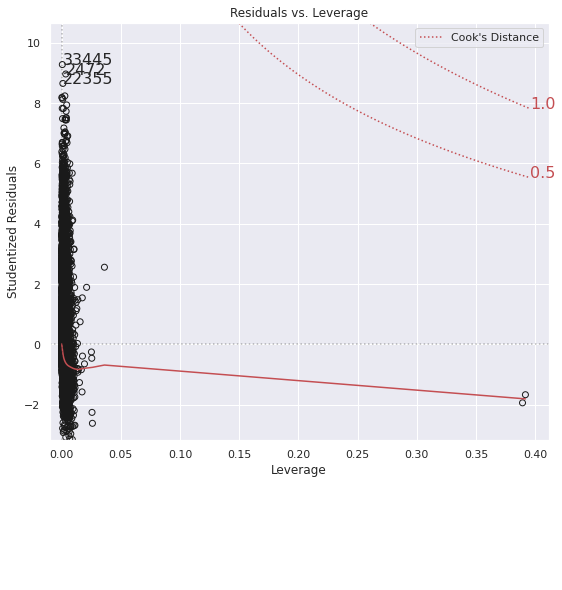

In [ ]:
# Checking leverage and residuals

student_residuals = pd.Series(ols_model_fitted.get_influence().resid_studentized_internal)
student_residuals.index = ols_model_fitted.resid.index
df = pd.DataFrame(student_residuals)
df.columns = ['student_residuals']
df['leverage'] = ols_model_fitted.get_influence().hat_matrix_diag
smoothed = lowess(df['student_residuals'],df['leverage'])
sorted_student_residuals = abs(df['student_residuals']).sort_values(ascending = False)
top3 = sorted_student_residuals[:3]

fig, ax = plt.subplots()
x = df['leverage']
y = df['student_residuals']
xpos = max(x)+max(x)*0.01  
ax.scatter(x, y, edgecolors = 'k', facecolors = 'none')
ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
ax.set_ylabel('Studentized Residuals')
ax.set_xlabel('Leverage')
ax.set_title('Residuals vs. Leverage')
ax.set_ylim(min(y)-min(y)*0.15,max(y)+max(y)*0.15)
ax.set_xlim(-0.01,max(x)+max(x)*0.05)
plt.tight_layout()
for val in top3.index:
    ax.annotate(val,xy=(x.loc[val],y.loc[val]))

cooksx = np.linspace(min(x), xpos, 50)
p = len(ols_model_fitted.params)
poscooks1y = np.sqrt((p*(1-cooksx))/cooksx)
poscooks05y = np.sqrt(0.5*(p*(1-cooksx))/cooksx)
negcooks1y = -np.sqrt((p*(1-cooksx))/cooksx)
negcooks05y = -np.sqrt(0.5*(p*(1-cooksx))/cooksx)

ax.plot(cooksx,poscooks1y,label = "Cook's Distance", ls = ':', color = 'r')
ax.plot(cooksx,poscooks05y, ls = ':', color = 'r')
ax.plot(cooksx,negcooks1y, ls = ':', color = 'r')
ax.plot(cooksx,negcooks05y, ls = ':', color = 'r')
ax.plot([0,0],ax.get_ylim(), ls=":", alpha = .3, color = 'k')
ax.plot(ax.get_xlim(), [0,0], ls=":", alpha = .3, color = 'k')
ax.annotate('1.0', xy = (xpos, poscooks1y[-1]), color = 'r')
ax.annotate('0.5', xy = (xpos, poscooks05y[-1]), color = 'r')
ax.annotate('1.0', xy = (xpos, negcooks1y[-1]), color = 'r')
ax.annotate('0.5', xy = (xpos, negcooks05y[-1]), color = 'r')
ax.legend()
plt.show()

In [ ]:
## NOTE: COMMENTED OUT DUE TO RUNTIME

# Looking at records with high leverage and influence

# Create summary_info
# summary_info = ols_model_fitted.get_influence().summary_frame()

# Copying training set
# training_data = X_train_no_na.copy()

# Adding points from Y
# training_data['points'] = Y_train_no_na

# Add the hat_diag column to training set
# training_data["leverage"] = summary_info["hat_diag"]

# Add the cooks_d column to training set
# training_data["cooks_dist"] = summary_info["cooks_d"]

In [ ]:
# Sort by leverage in descending order and print the head
# print(training_data.sort_values(by=['leverage'],ascending=False).head())

In [ ]:
# Sort by cooks distance in descending order and print the head
# print(training_data.sort_values(by=['cooks_dist'],ascending=False).head())

### Diagnostic plots with rounded predictions

In [ ]:
# Set up
residuals = round(ols_model_fitted.resid,0)
fitted = round(ols_model_fitted.fittedvalues,0)
smoothed = lowess(residuals,fitted)

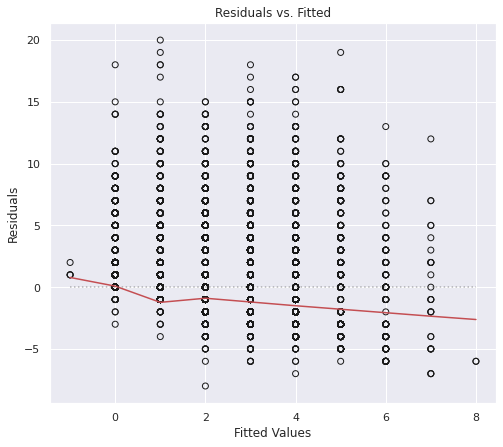

In [ ]:
# Checking residuals
plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (8,7)
fig, ax = plt.subplots()
ax.scatter(fitted, residuals, edgecolors = 'k', facecolors = 'none')
ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
ax.set_ylabel('Residuals')
ax.set_xlabel('Fitted Values')
ax.set_title('Residuals vs. Fitted')
ax.plot([min(fitted),max(fitted)],[0,0],color = 'k',linestyle = ':', alpha = .3)

plt.show()

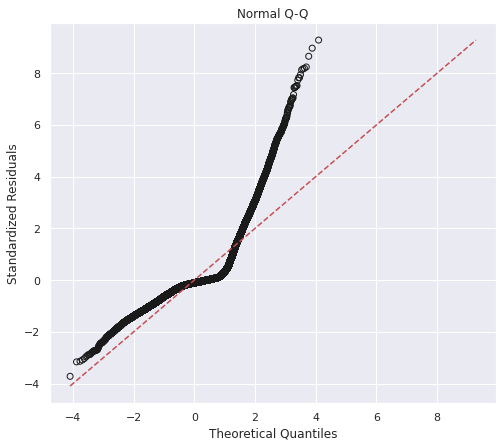

In [ ]:
# Checking QQ plot
sorted_student_residuals = pd.Series(ols_model_fitted.get_influence().resid_studentized_internal)
sorted_student_residuals.index = ols_model_fitted.resid.index
sorted_student_residuals = sorted_student_residuals.sort_values(ascending = True)
df = pd.DataFrame(sorted_student_residuals)
df.columns = ['sorted_student_residuals']
df['theoretical_quantiles'] = stats.probplot(df['sorted_student_residuals'], dist = 'norm', fit = False)[0]
rankings = abs(df['sorted_student_residuals']).sort_values(ascending = False)

fig, ax = plt.subplots()
x = df['theoretical_quantiles']
y = df['sorted_student_residuals']
ax.scatter(x,y, edgecolor = 'k',facecolor = 'none')
ax.set_title('Normal Q-Q')
ax.set_ylabel('Standardized Residuals')
ax.set_xlabel('Theoretical Quantiles')
ax.plot([np.min([x,y]),np.max([x,y])],[np.min([x,y]),np.max([x,y])], color = 'r', ls = '--')

plt.show()

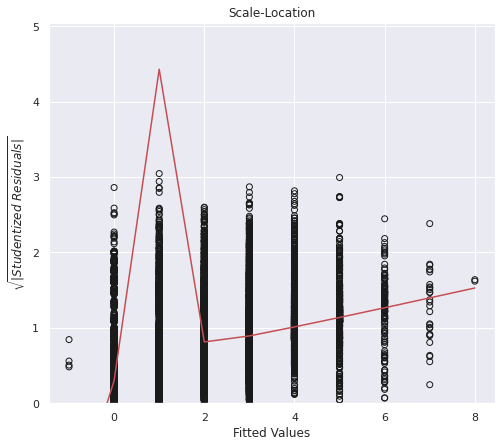

In [ ]:
# Scale-Location plot
student_residuals = ols_model_fitted.get_influence().resid_studentized_internal
sqrt_student_residuals = pd.Series(np.sqrt(np.abs(student_residuals)))
sqrt_student_residuals.index = ols_model_fitted.resid.index
smoothed = lowess(sqrt_student_residuals,fitted)

fig, ax = plt.subplots()
ax.scatter(fitted, sqrt_student_residuals, edgecolors = 'k', facecolors = 'none')
ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
ax.set_ylabel('$\sqrt{|Studentized \ Residuals|}$')
ax.set_xlabel('Fitted Values')
ax.set_title('Scale-Location')
ax.set_ylim(0,max(sqrt_student_residuals)+2)

plt.show()

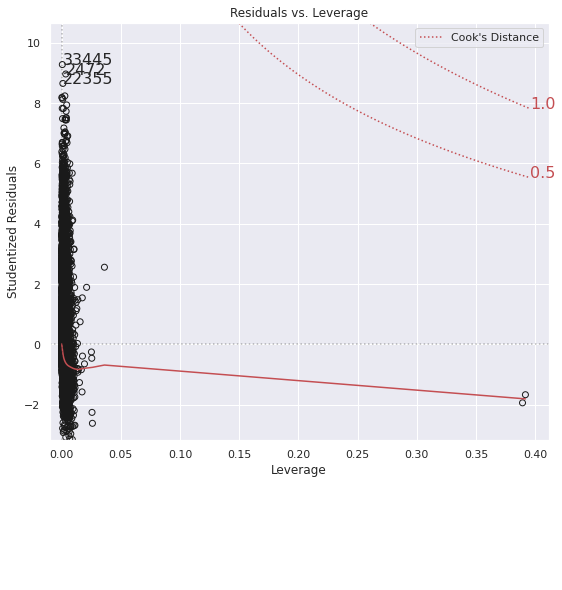

In [ ]:
# Checking leverage and residuals

student_residuals = pd.Series(ols_model_fitted.get_influence().resid_studentized_internal)
student_residuals.index = ols_model_fitted.resid.index
df = pd.DataFrame(student_residuals)
df.columns = ['student_residuals']
df['leverage'] = ols_model_fitted.get_influence().hat_matrix_diag
smoothed = lowess(df['student_residuals'],df['leverage'])
sorted_student_residuals = abs(df['student_residuals']).sort_values(ascending = False)
top3 = sorted_student_residuals[:3]

fig, ax = plt.subplots()
x = df['leverage']
y = df['student_residuals']
xpos = max(x)+max(x)*0.01  
ax.scatter(x, y, edgecolors = 'k', facecolors = 'none')
ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
ax.set_ylabel('Studentized Residuals')
ax.set_xlabel('Leverage')
ax.set_title('Residuals vs. Leverage')
ax.set_ylim(min(y)-min(y)*0.15,max(y)+max(y)*0.15)
ax.set_xlim(-0.01,max(x)+max(x)*0.05)
plt.tight_layout()
for val in top3.index:
    ax.annotate(val,xy=(x.loc[val],y.loc[val]))

cooksx = np.linspace(min(x), xpos, 50)
p = len(ols_model_fitted.params)
poscooks1y = np.sqrt((p*(1-cooksx))/cooksx)
poscooks05y = np.sqrt(0.5*(p*(1-cooksx))/cooksx)
negcooks1y = -np.sqrt((p*(1-cooksx))/cooksx)
negcooks05y = -np.sqrt(0.5*(p*(1-cooksx))/cooksx)

ax.plot(cooksx,poscooks1y,label = "Cook's Distance", ls = ':', color = 'r')
ax.plot(cooksx,poscooks05y, ls = ':', color = 'r')
ax.plot(cooksx,negcooks1y, ls = ':', color = 'r')
ax.plot(cooksx,negcooks05y, ls = ':', color = 'r')
ax.plot([0,0],ax.get_ylim(), ls=":", alpha = .3, color = 'k')
ax.plot(ax.get_xlim(), [0,0], ls=":", alpha = .3, color = 'k')
ax.annotate('1.0', xy = (xpos, poscooks1y[-1]), color = 'r')
ax.annotate('0.5', xy = (xpos, poscooks05y[-1]), color = 'r')
ax.annotate('1.0', xy = (xpos, negcooks1y[-1]), color = 'r')
ax.annotate('0.5', xy = (xpos, negcooks05y[-1]), color = 'r')
ax.legend()
plt.show()

## Removing variables that are not significant at a 95% confidence level

In [ ]:
# Extracting pvalues
pvalues = ols_model_fitted.pvalues

# Extracting significant pvalues
significant_pvalues = pvalues[pvalues <= 0.05]

# Significant variables
significant_variables = list(significant_pvalues.index)

print(significant_variables)

['opponent_strength', 'points_lag_1', 'points_lag_2', 'points_lag_3', 'points_lag_4', 'points_lag_5', 'minutes_lag', 'minutes_rolling', 'goals_scored_lag', 'assists_lag', 'saves_rolling', 'cards_lag', 'bonus_rolling', 'creativity_rolling', 'threat_lag', 'threat_rolling', 'transfers_in_ratio_lag', 'transfers_in_ratio_rolling', 'transfers_out_ratio_rolling', 'was_home_True', 'position_FWD', 'position_MID']


In [ ]:
# Reviewing removed variables
not_significant_pvalues = pvalues[pvalues > 0.05]
print(not_significant_pvalues)

goals_scored_rolling       0.343186
assists_rolling            0.355449
clean_sheets_lag           0.053836
clean_sheets_rolling       0.094087
goals_conceded_lag         0.278700
goals_conceded_rolling     0.321404
saves_lag                  0.803655
cards_rolling              0.152825
bonus_lag                  0.051746
bps_lag                    0.935533
bps_rolling                0.136328
influence_lag              0.915193
influence_rolling          0.056793
creativity_lag             0.823621
selected_lag               0.147793
selected_rolling           0.095647
transfers_out_ratio_lag    0.841149
position_GKP               0.390470
dtype: float64


In [ ]:
# Selecting only significant variables
X_train_no_na_sig = X_train_no_na[significant_variables].copy()
X_test_no_na_sig = X_test_no_na[significant_variables].copy()

In [ ]:
# Build OLS linear regression model
ols_model = sm.OLS(Y_train_no_na, X_train_no_na_sig)
ols_model_fitted = ols_model.fit()

In [ ]:
#Fitted results
print(ols_model_fitted.summary())

                                 OLS Regression Results                                
Dep. Variable:           total_points   R-squared (uncentered):                   0.442
Model:                            OLS   Adj. R-squared (uncentered):              0.441
Method:                 Least Squares   F-statistic:                              1175.
Date:                Fri, 07 May 2021   Prob (F-statistic):                        0.00
Time:                        08:10:18   Log-Likelihood:                         -71922.
No. Observations:               32698   AIC:                                  1.439e+05
Df Residuals:                   32676   BIC:                                  1.441e+05
Df Model:                          22                                                  
Covariance Type:            nonrobust                                                  
                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------

In [ ]:
# Predicting on test
y_pred_ols = ols_model_fitted.predict(X_test_no_na_sig)

In [ ]:
# Checking min/max prediction
min_pred = min(y_pred_ols)
max_pred = max(y_pred_ols)
print("Min prediction: {}".format(min_pred))
print("Max prediction: {}".format(max_pred))

Min prediction: -0.6298627335679681
Max prediction: 6.969324723387104


In [ ]:
# Checking MSE
mse = mean_squared_error(Y_test_no_na, y_pred_ols)
print("Test MSE: {}".format(mse))

Test MSE: 4.8108829750362


In [ ]:
# Checking R2
r2 = r2_score(Y_test_no_na, y_pred_ols)
print("Test R2: {}".format(r2))

Test R2: 0.2443158699263519


### Diagnostic plots

In [ ]:
# Set up
residuals = ols_model_fitted.resid
fitted = ols_model_fitted.fittedvalues
smoothed = lowess(residuals,fitted)

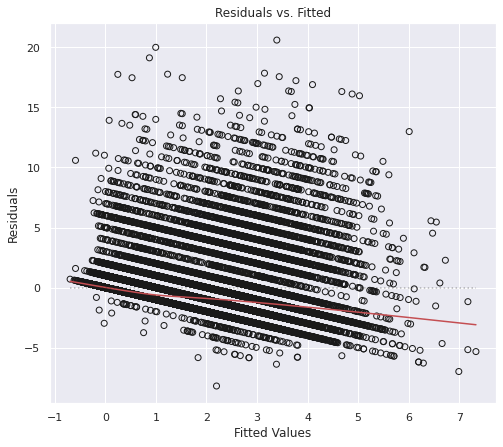

In [ ]:
# Checking residuals
plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (8,7)
fig, ax = plt.subplots()
ax.scatter(fitted, residuals, edgecolors = 'k', facecolors = 'none')
ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
ax.set_ylabel('Residuals')
ax.set_xlabel('Fitted Values')
ax.set_title('Residuals vs. Fitted')
ax.plot([min(fitted),max(fitted)],[0,0],color = 'k',linestyle = ':', alpha = .3)

plt.show()

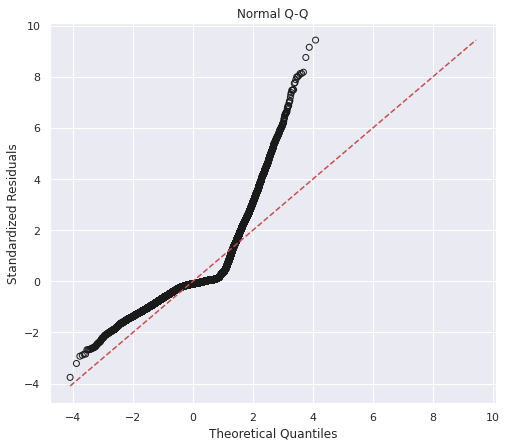

In [ ]:
# Checking QQ plot
sorted_student_residuals = pd.Series(ols_model_fitted.get_influence().resid_studentized_internal)
sorted_student_residuals.index = ols_model_fitted.resid.index
sorted_student_residuals = sorted_student_residuals.sort_values(ascending = True)
df = pd.DataFrame(sorted_student_residuals)
df.columns = ['sorted_student_residuals']
df['theoretical_quantiles'] = stats.probplot(df['sorted_student_residuals'], dist = 'norm', fit = False)[0]
rankings = abs(df['sorted_student_residuals']).sort_values(ascending = False)

fig, ax = plt.subplots()
x = df['theoretical_quantiles']
y = df['sorted_student_residuals']
ax.scatter(x,y, edgecolor = 'k',facecolor = 'none')
ax.set_title('Normal Q-Q')
ax.set_ylabel('Standardized Residuals')
ax.set_xlabel('Theoretical Quantiles')
ax.plot([np.min([x,y]),np.max([x,y])],[np.min([x,y]),np.max([x,y])], color = 'r', ls = '--')

plt.show()

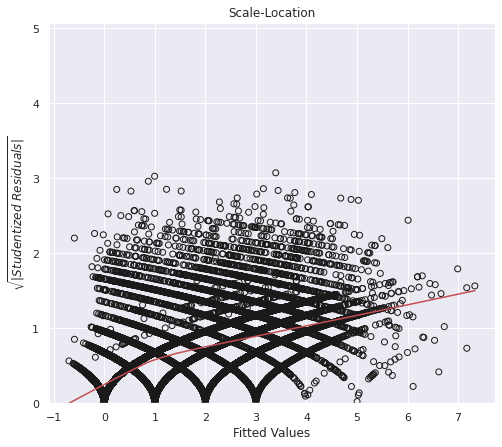

In [ ]:
# Scale-Location plot
student_residuals = ols_model_fitted.get_influence().resid_studentized_internal
sqrt_student_residuals = pd.Series(np.sqrt(np.abs(student_residuals)))
sqrt_student_residuals.index = ols_model_fitted.resid.index
smoothed = lowess(sqrt_student_residuals,fitted)

fig, ax = plt.subplots()
ax.scatter(fitted, sqrt_student_residuals, edgecolors = 'k', facecolors = 'none')
ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
ax.set_ylabel('$\sqrt{|Studentized \ Residuals|}$')
ax.set_xlabel('Fitted Values')
ax.set_title('Scale-Location')
ax.set_ylim(0,max(sqrt_student_residuals)+2)

plt.show()

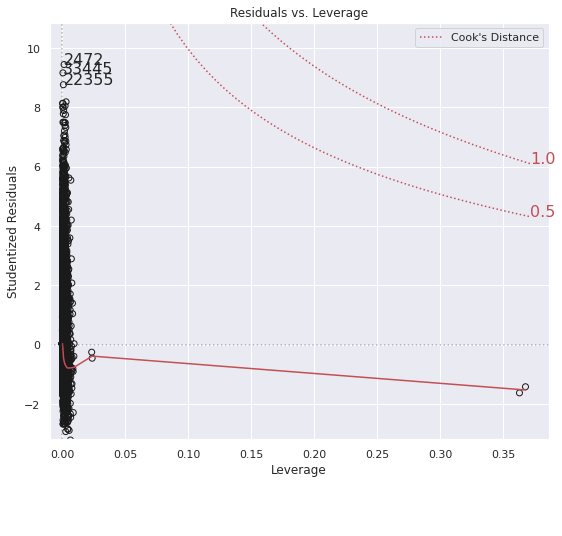

In [ ]:
# Checking leverage and residuals

student_residuals = pd.Series(ols_model_fitted.get_influence().resid_studentized_internal)
student_residuals.index = ols_model_fitted.resid.index
df = pd.DataFrame(student_residuals)
df.columns = ['student_residuals']
df['leverage'] = ols_model_fitted.get_influence().hat_matrix_diag
smoothed = lowess(df['student_residuals'],df['leverage'])
sorted_student_residuals = abs(df['student_residuals']).sort_values(ascending = False)
top3 = sorted_student_residuals[:3]

fig, ax = plt.subplots()
x = df['leverage']
y = df['student_residuals']
xpos = max(x)+max(x)*0.01  
ax.scatter(x, y, edgecolors = 'k', facecolors = 'none')
ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
ax.set_ylabel('Studentized Residuals')
ax.set_xlabel('Leverage')
ax.set_title('Residuals vs. Leverage')
ax.set_ylim(min(y)-min(y)*0.15,max(y)+max(y)*0.15)
ax.set_xlim(-0.01,max(x)+max(x)*0.05)
plt.tight_layout()
for val in top3.index:
    ax.annotate(val,xy=(x.loc[val],y.loc[val]))

cooksx = np.linspace(min(x), xpos, 50)
p = len(ols_model_fitted.params)
poscooks1y = np.sqrt((p*(1-cooksx))/cooksx)
poscooks05y = np.sqrt(0.5*(p*(1-cooksx))/cooksx)
negcooks1y = -np.sqrt((p*(1-cooksx))/cooksx)
negcooks05y = -np.sqrt(0.5*(p*(1-cooksx))/cooksx)

ax.plot(cooksx,poscooks1y,label = "Cook's Distance", ls = ':', color = 'r')
ax.plot(cooksx,poscooks05y, ls = ':', color = 'r')
ax.plot(cooksx,negcooks1y, ls = ':', color = 'r')
ax.plot(cooksx,negcooks05y, ls = ':', color = 'r')
ax.plot([0,0],ax.get_ylim(), ls=":", alpha = .3, color = 'k')
ax.plot(ax.get_xlim(), [0,0], ls=":", alpha = .3, color = 'k')
ax.annotate('1.0', xy = (xpos, poscooks1y[-1]), color = 'r')
ax.annotate('0.5', xy = (xpos, poscooks05y[-1]), color = 'r')
ax.annotate('1.0', xy = (xpos, negcooks1y[-1]), color = 'r')
ax.annotate('0.5', xy = (xpos, negcooks05y[-1]), color = 'r')
ax.legend()
plt.show()